In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, Subset


(thanks to carlos for the functions 😬)

In [2]:
def plot_lr(epochs, lrs):
    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Linear scale plot
    ax1.plot(epochs, lrs, marker='o')
    ax1.set_title('Learning Rate per Epoch (Linear Scale)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_xticks(epochs)
    ax1.grid(True)

    # Log scale plot
    ax2.plot(epochs, lrs, marker='o')
    ax2.set_title('Learning Rate per Epoch (Log Scale)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.set_xticks(epochs)
    ax2.grid(True)

    # Display the plots
    plt.show()

In [3]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=512, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,2)
        )

        for m in self.modules():
            if not RCNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

# Visualize the different learning rate scheduler over 100 epochs

In [4]:
num_epochs = 100
initial_lr = 1e-3
model = RCNN()

batch_size = 2

## 1. Exponential decay

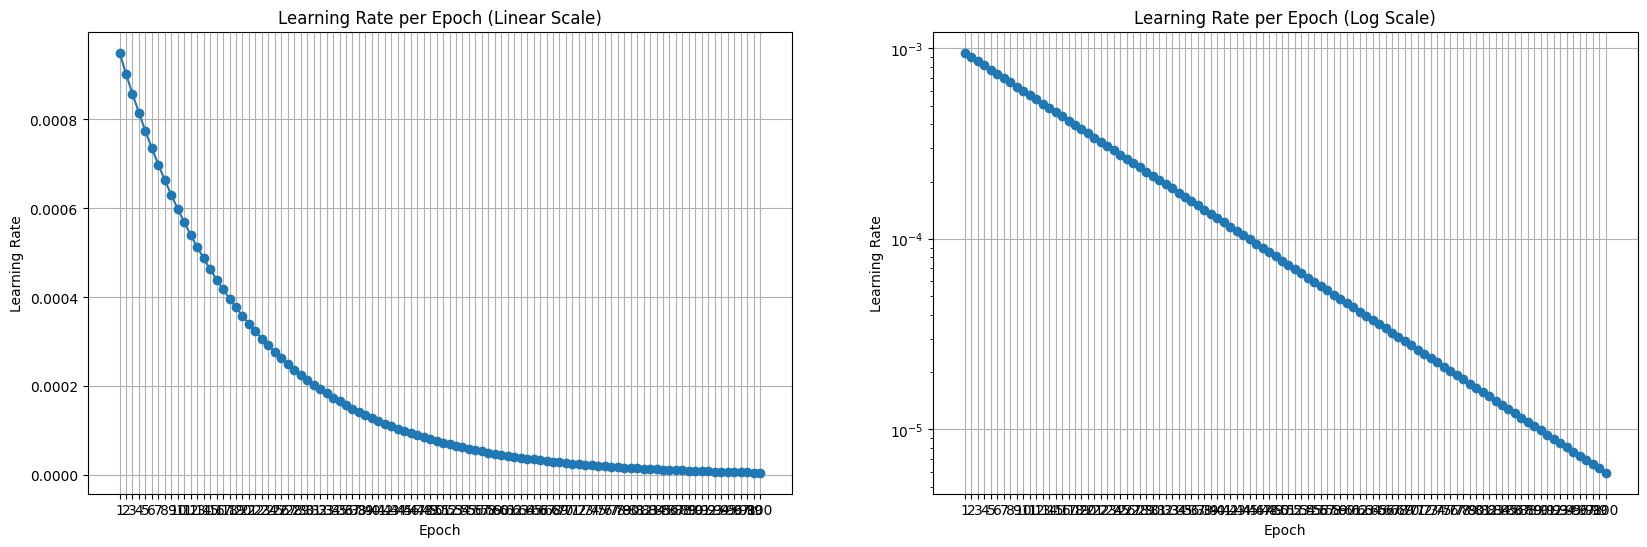

In [5]:
weight_decay = 200

# Function to create optimizer and scheduler
def reset_optimizer_scheduler():
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3, factor=0.75)

    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = reset_optimizer_scheduler()

# Lists to store epoch numbers and corresponding learning rates
epochs = []
lrs = []

# Loop to update and record learning rate
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs.append(epoch + 1)
    lrs.append(current_lr)

plot_lr(epochs, lrs)

## 2. Cosine annealing

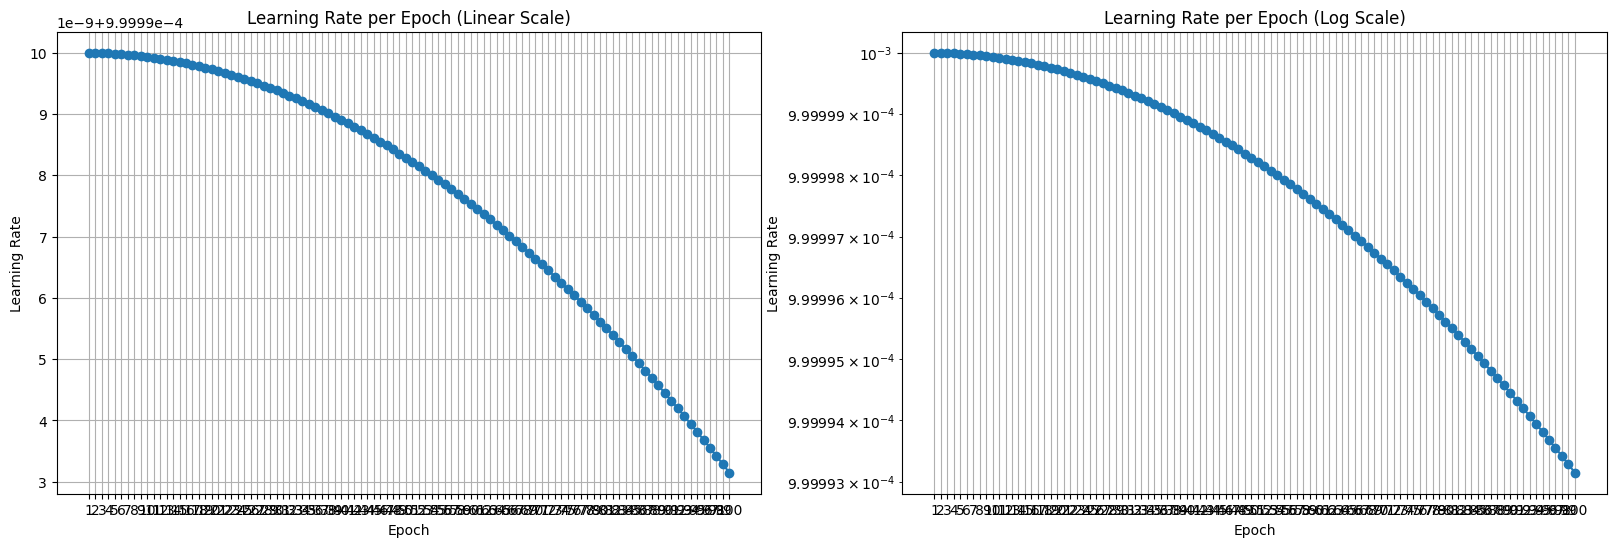

In [18]:
weight_decay = 200

# Function to create optimizer and scheduler
def reset_optimizer_scheduler():
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( #designed to adapt the learning rate during epochs
    optimizer,
    T_max=(1200 * num_epochs) // batch_size,
    )
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3, factor=0.75)

    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = reset_optimizer_scheduler()

# Lists to store epoch numbers and corresponding learning rates
epochs = []
lrs = []

# Loop to update and record learning rate
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs.append(epoch + 1)
    lrs.append(current_lr)

plot_lr(epochs, lrs)

## 3. Step decay

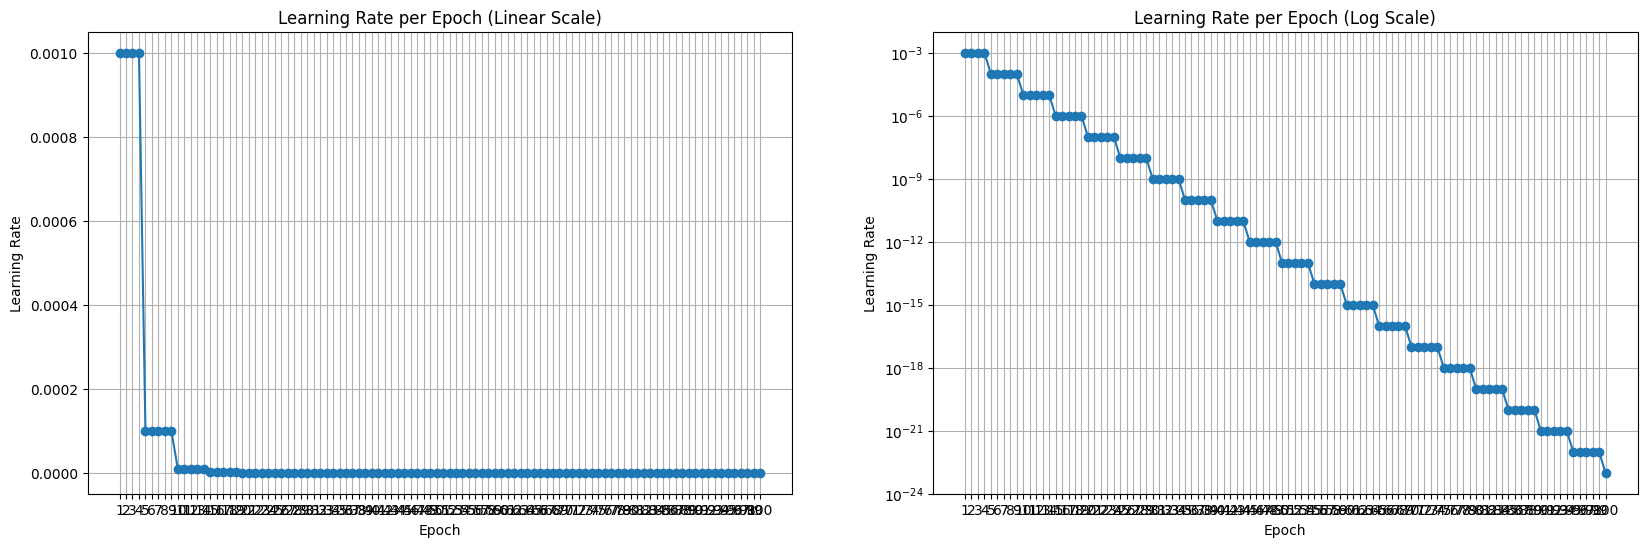

In [19]:
weight_decay = 200

# Function to create optimizer and scheduler
def reset_optimizer_scheduler():
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = reset_optimizer_scheduler()

# Lists to store epoch numbers and corresponding learning rates
epochs = []
lrs = []

# Loop to update and record learning rate
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs.append(epoch + 1)
    lrs.append(current_lr)

plot_lr(epochs, lrs)

## 4. Multisteps decay

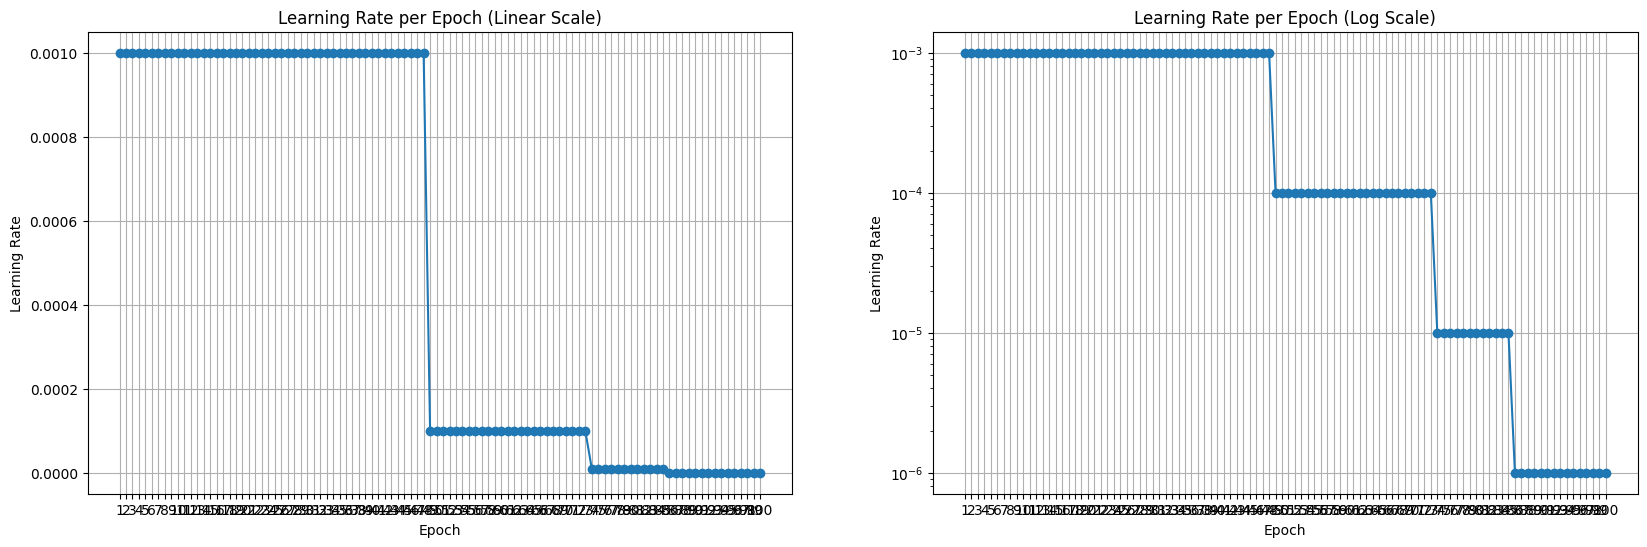

In [20]:
weight_decay = 200

# Function to create optimizer and scheduler
def reset_optimizer_scheduler():
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epoch/2),int(epoch*3/4),int(epoch*7/8)], gamma=0.1)
    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = reset_optimizer_scheduler()

# Lists to store epoch numbers and corresponding learning rates
epochs = []
lrs = []

# Loop to update and record learning rate
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs.append(epoch + 1)
    lrs.append(current_lr)

plot_lr(epochs, lrs)